In [2]:
import pandas as pd 
data=pd.read_csv('/Users/s/Desktop/mlops/network_Security_end2end/artifact/data/processed/train.csv')
group_mapping = {
    'BENIGN': 'Normal Traffic',
    'DoS Hulk': 'DoS',
    'DDoS': 'DDoS',
    'PortScan': 'Port Scanning',
    'DoS GoldenEye': 'DoS',
    'FTP-Patator': 'Brute Force',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'SSH-Patator': 'Brute Force',
    'Bot': 'Bots',
    'Web Attack � Brute Force': 'Web Attacks',
    'Web Attack � XSS': 'Web Attacks',
    'Infiltration': 'Infiltration',
    'Web Attack � Sql Injection': 'Web Attacks',
    'Heartbleed': 'Miscellaneous'
}

data['Attack Type'] = data['Label'].map(group_mapping)

In [3]:
data['Attack Type'].value_counts()

Attack Type
Normal Traffic    1062672
DoS                118118
Port Scanning       74299
DDoS                59853
Brute Force          6468
Web Attacks          1020
Bots                  919
Infiltration           17
Miscellaneous           5
Name: count, dtype: int64

In [4]:
data.drop(columns='Label', inplace=True)

In [5]:
X=data.drop(columns=['Attack Type'])
y=data['Attack Type']

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Attack Type'] = le.fit_transform(data['Attack Type'])
data['Attack Type'].value_counts()

Attack Type
6    1062672
3     118118
7      74299
2      59853
1       6468
8       1020
0        919
4         17
5          5
Name: count, dtype: int64

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

X = pd.DataFrame(X).fillna(0)

X = np.where(np.isinf(X), 0, X)

imputer = SimpleImputer(strategy='constant', fill_value=0)
X = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=pd.DataFrame(X).columns)



In [2]:
!pip install shap

  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/5f/9e/dce41d5ec9e79add65faf4381d8d4492247b29daaa6cc7d7fd0298abc1e2/shap-0.46.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for slicer==0.0.8 from https://files.pythonhosted.org/packages/63/81/9ef641ff4e12cbcca30e54e72fb0951a2ba195d0cda0ba4100e532d929db/slicer-0.0.8-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 5.2 MB/s eta 0:00:00a 0:00:01


In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFECV
from lightgbm import LGBMClassifier  # LightGBM (Faster than RF)
import shap

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.3, random_state=42)

# Using LightGBM Instead of RF
model = LGBMClassifier(n_estimators=200, learning_rate=0.05, max_depth=10, random_state=42)

# SHAP Feature Selection
model.fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)[1]  # Get class 1 SHAP values

# Compute Mean SHAP Importance
shap_importance = pd.DataFrame({
    'Feature': X_scaled_df.columns,
    'SHAP_Importance': np.abs(shap_values).mean(axis=0)
}).sort_values(by='SHAP_Importance', ascending=False)

# Recursive Feature Elimination with Cross-Validation
rfecv = RFECV(estimator=model, step=1, cv=5, scoring='accuracy', n_jobs=-1)
rfecv.fit(X_train, y_train)

# Select the Best Features
selected_features = X_scaled_df.columns[rfecv.support_]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Train Final Model
final_model = LGBMClassifier(n_estimators=300, learning_rate=0.03, max_depth=12, random_state=42)
final_model.fit(X_train_selected, y_train)

# Evaluate
cv_score = np.mean(cross_val_score(final_model, X_train_selected, y_train, cv=5, scoring='accuracy'))
print(f"\nOptimized CV Score: {cv_score:.6f}")
print(f"Selected Features: {list(selected_features)}")


ModuleNotFoundError: No module named 'shap'

In [22]:
feature_importances.to_csv('i.csv')

In [14]:
max_importance = feature_importances['Importance'].max()
feature_importances['Normalized_Importance'] = feature_importances['Importance'] / max_importance

threshold = 0.05  
threshold_value = threshold * max_importance

important_features = feature_importances[feature_importances['Importance'] >= threshold_value]

features_to_remove = feature_importances[feature_importances['Importance'] < threshold_value]

print("Features to keep:")
print(important_features)

print("\nFeatures to remove:")
print(features_to_remove)

Features to keep:
    Feature  Importance  Normalized_Importance
42       42    0.054726               1.000000
41       41    0.053957               0.985951
39       39    0.052657               0.962195
54       54    0.045941               0.839467
0         0    0.045515               0.831691
63       63    0.040766               0.744916
52       52    0.037657               0.688101
10       10    0.037336               0.682233
4         4    0.034248               0.625806
13       13    0.033366               0.609690
6         6    0.028405               0.519047
66       66    0.027320               0.499223
5         5    0.026142               0.477686
12       12    0.024007               0.438683
8         8    0.021852               0.399301
40       40    0.021654               0.395680
65       65    0.021401               0.391061
53       53    0.021069               0.384990
55       55    0.019286               0.352418
69       69    0.017068               0.31

/Users/s/Desktop/mlops/network_Security_end2end/networkenv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Threshold: 0.05, CV Score: 0.9987


/Users/s/Desktop/mlops/network_Security_end2end/networkenv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Threshold: 0.10, CV Score: 0.9987


/Users/s/Desktop/mlops/network_Security_end2end/networkenv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Threshold: 0.15, CV Score: 0.9987


/Users/s/Desktop/mlops/network_Security_end2end/networkenv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Threshold: 0.20, CV Score: 0.9989


/Users/s/Desktop/mlops/network_Security_end2end/networkenv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Threshold: 0.25, CV Score: 0.9980


/Users/s/Desktop/mlops/network_Security_end2end/networkenv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Threshold: 0.30, CV Score: 0.9983


/Users/s/Desktop/mlops/network_Security_end2end/networkenv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Threshold: 0.35, CV Score: 0.9981


/Users/s/Desktop/mlops/network_Security_end2end/networkenv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Threshold: 0.40, CV Score: 0.9960


/Users/s/Desktop/mlops/network_Security_end2end/networkenv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Threshold: 0.45, CV Score: 0.9960


/Users/s/Desktop/mlops/network_Security_end2end/networkenv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Threshold: 0.50, CV Score: 0.9767

Best Threshold: 0.20
Best CV Score: 0.9989
Selected Features: [42, 41, 39, 54, 0, 63, 52, 10, 4, 13, 6, 66, 5, 12, 8, 40, 65, 53, 55, 69, 67, 35, 34, 17, 62, 74, 2, 37, 14, 68, 46, 23]


ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

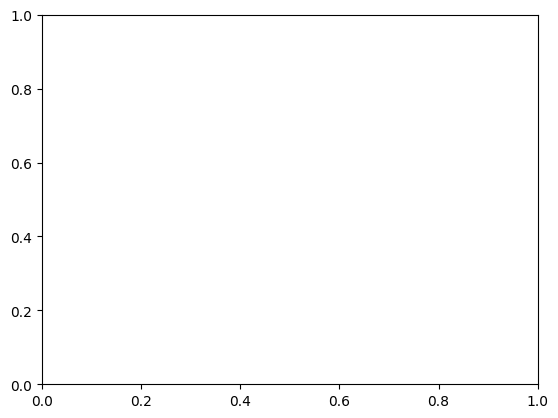

In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt


max_importance = feature_importances['Importance'].max()
feature_importances['Normalized_Importance'] = feature_importances['Importance'] / max_importance

thresholds = np.linspace(0.05, 0.5, 10)  
best_score = -np.inf
best_threshold = None
best_model = None
best_features = None

for threshold in thresholds:
    threshold_value = threshold * max_importance
    selected_features = feature_importances[feature_importances['Importance'] >= threshold_value]['Feature']
    X_selected = X_scaled_df[selected_features]
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))
    if cv_score > best_score:
        best_score = cv_score
        best_threshold = threshold
        best_model = model
        best_features = selected_features

    print(f"Threshold: {threshold:.2f}, CV Score: {cv_score:.4f}")

print(f"\nBest Threshold: {best_threshold:.2f}")
print(f"Best CV Score: {best_score:.4f}")
print(f"Selected Features: {best_features.tolist()}")

